# Clientes Fieles

### Antes

In [1]:
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os

In [3]:
df_clientes = pd.read_csv(os.path.join("datos", "data_sales.csv"), sep=";")

In [57]:
#df_items = pd.read_csv("/content/data_items.csv", delimiter = ";")

In [4]:
fecha_mas_reciente = df_clientes['date'].max()
print(fecha_mas_reciente)

2024-03-04


In [61]:
df_clientes.dtypes

item_id                    int64
date                      object
quantity                   int64
unit_sale_price (CLP)    float64
total (CLP)              float64
client_id                float64
dtype: object

### Funciones

In [ ]:
def promedio_compras_totales_por_mes(df_clientes, anio):
    df_anio = df_clientes[df_clientes['date'].dt.year == anio]
    compras_por_mes = df_anio.groupby(df_anio['date'].dt.month)['quantity'].sum().mean()
    return compras_por_mes

In [ ]:
def clientes_fieles(df_clientes, anio):
    df_anio = df_clientes[df_clientes['date'].dt.year == anio]

    if anio == 2024:
        fecha_mas_reciente = df_anio['date'].max()
        mes_anterior = fecha_mas_reciente.month - 1
        df_anio = df_anio[df_anio['date'].dt.month <= mes_anterior]

    compras_por_cliente_mes = df_anio.groupby(['client_id', df_anio['date'].dt.month]).size().reset_index(name='compras')
    primer_mes_compra = df_anio.groupby('client_id')['date'].min().dt.month

    clientes_fieles = []
    for client_id, primer_mes in primer_mes_compra.items():
        if anio == 2024:
            meses_esperados = set(range(primer_mes, mes_anterior + 1))
        else:
            meses_esperados = set(range(primer_mes, 13))

        meses_compra_cliente = set(compras_por_cliente_mes[compras_por_cliente_mes['client_id'] == client_id]['date'])

        # Verificar si la primera compra es en diciembre y el año es diferente al año actual
        if primer_mes == 12 and df_clientes[df_clientes['client_id'] == client_id]['date'].dt.year.min() != anio:
            continue

        if meses_esperados.issubset(meses_compra_cliente):
            clientes_fieles.append(client_id)

    return clientes_fieles

In [ ]:
def clientes_fieles_por_mes(df_clientes):
    clientes_fieles_por_mes_anio = {}

    for anio in range(2020, 2024):
        clientes_fieles_anio = clientes_fieles(df_clientes, anio)
        clientes_por_mes = {}
        for mes in range(1, 13):
            clientes_por_mes[mes] = sum(1 for client_id in clientes_fieles_anio if cliente_realizo_compra_mes(df_clientes, client_id, anio, mes))
        clientes_fieles_por_mes_anio[anio] = clientes_por_mes

    return clientes_fieles_por_mes_anio

In [ ]:
def cliente_realizo_compra_mes(df_clientes, client_id, anio, mes):
    df_anio_mes = df_clientes[(df_clientes['date'].dt.year == anio) & (df_clientes['date'].dt.month == mes)]
    return client_id in df_anio_mes['client_id'].values

In [ ]:
def promedio_compras_por_mes_por_cliente_fiel(df_clientes, anio):

    df_anio = df_clientes[df_clientes['date'].dt.year == anio]

    if anio == 2024:
        fecha_mas_reciente = df_anio['date'].max()
        mes_anterior = fecha_mas_reciente.month - 1
        df_anio = df_anio[df_anio['date'].dt.month <= mes_anterior]

    clientes_fieles_anio = clientes_fieles(df_anio, anio)
    df_clientes_fieles_anio = df_anio[df_anio['client_id'].isin(clientes_fieles_anio)]
    compras_por_cliente_mes = df_clientes_fieles_anio.groupby(['client_id', df_clientes_fieles_anio['date'].dt.month]).size().reset_index(name='compras')
    promedio_compras_por_mes_por_cliente = compras_por_cliente_mes.groupby('client_id')['compras'].mean()

    return promedio_compras_por_mes_por_cliente

In [ ]:
def compras_por_mes(df_clientes, anio):

    df_anio = df_clientes[df_clientes['date'].dt.year == anio]

    if anio == 2024:
        fecha_mas_reciente = df_anio['date'].max()
        mes_anterior = fecha_mas_reciente.month - 1
        df_anio = df_anio[df_anio['date'].dt.month <= mes_anterior]

    clientes_fieles_anio = clientes_fieles(df_anio, anio)
    df_clientes_fieles_anio = df_anio[df_anio['client_id'].isin(clientes_fieles_anio)]
    compras_clientes_fieles_por_mes = df_clientes_fieles_anio.groupby(df_clientes_fieles_anio['date'].dt.month)['quantity'].mean()

    return compras_clientes_fieles_por_mes

In [ ]:
def ganancias_por_mes(df_clientes, anio):

    df_anio = df_clientes[df_clientes['date'].dt.year == anio]

    if anio == 2024:
        fecha_mas_reciente = df_anio['date'].max()
        mes_anterior = fecha_mas_reciente.month - 1
        df_anio = df_anio[df_anio['date'].dt.month <= mes_anterior]

    ganancias_totales_por_mes = df_anio.groupby(df_anio['date'].dt.month)['total (CLP)'].sum()
    clientes_fieles_anio = clientes_fieles(df_anio, anio)
    df_clientes_fieles_anio = df_anio[df_anio['client_id'].isin(clientes_fieles_anio)]
    ganancias_clientes_fieles_por_mes = df_clientes_fieles_anio.groupby(df_clientes_fieles_anio['date'].dt.month)['total (CLP)'].sum()
    porcentaje_contribucion_clientes_fieles_por_mes = (ganancias_clientes_fieles_por_mes / ganancias_totales_por_mes) * 100

    return porcentaje_contribucion_clientes_fieles_por_mes

In [ ]:
def productos_comprados_por_clientes_fieles(df_clientes, anio):

    df_anio = df_clientes[df_clientes['date'].dt.year == anio]
    clientes_fieles_anio = clientes_fieles(df_anio, anio)
    df_clientes_fieles_anio = df_anio[df_anio['client_id'].isin(clientes_fieles_anio)]
    productos_comprados = df_clientes_fieles_anio.groupby('item_id')['quantity'].sum().reset_index()
    productos_comprados = productos_comprados.sort_values(by='quantity', ascending=False)

    return productos_comprados

In [ ]:
def productos_comprados_por_clientes(df_clientes, anio):
    df_anio = df_clientes[df_clientes['date'].dt.year == anio]
    productos_por_anio = df_anio.groupby('item_id')['quantity'].sum().reset_index()
    productos_por_anio = productos_por_anio.sort_values(by='quantity', ascending=False)
    return productos_por_anio

In [ ]:
def productos_comprados_por_clientes_no_fieles(df_clientes, anio, clientes_fieles):
    df_anio = df_clientes[df_clientes['date'].dt.year == anio]
    df_no_fieles = df_anio[~df_anio['customer_id'].isin(clientes_fieles)]
    productos_por_anio = df_no_fieles.groupby('item_id')['quantity'].sum().reset_index()
    return productos_por_anio

In [ ]:
def clientes_no_fieles(df_clientes, anio):
    df_anio = df_clientes[df_clientes['date'].dt.year == anio]

    if anio == 2024:
        fecha_mas_reciente = df_anio['date'].max()
        mes_anterior = fecha_mas_reciente.month - 1
        df_anio = df_anio[df_anio['date'].dt.month <= mes_anterior]

    compras_por_cliente_mes = df_anio.groupby(['client_id', df_anio['date'].dt.month]).size().reset_index(name='compras')
    primer_mes_compra = df_anio.groupby('client_id')['date'].min().dt.month

    clientes_no_fieles = []
    for client_id, primer_mes in primer_mes_compra.items():
        if anio == 2024:
            meses_esperados = set(range(primer_mes, mes_anterior + 1))
        else:
            meses_esperados = set(range(primer_mes, 13))
        meses_compra_cliente = set(compras_por_cliente_mes[compras_por_cliente_mes['client_id'] == client_id]['date'])
        if meses_esperados.issubset(meses_compra_cliente):
            pass
        else:
            clientes_no_fieles.append(client_id)


    return clientes_no_fieles

In [ ]:
def productos_comprados_por_clientes_no_fieles(df_clientes, anio):

    df_anio = df_clientes[df_clientes['date'].dt.year == anio]
    clientes_no_fieles_anio = clientes_no_fieles(df_anio, anio)
    df_clientes_no_fieles_anio = df_anio[df_anio['client_id'].isin(clientes_no_fieles_anio)]
    productos_comprados = df_clientes_no_fieles_anio.groupby('item_id')['quantity'].sum().reset_index()
    productos_comprados = productos_comprados.sort_values(by='quantity', ascending=False)

    return productos_comprados

### Clientes fieles por año

In [ ]:
df_clientes['date'] = pd.to_datetime(df_clientes['date'])
anios_unicos = sorted(df_clientes['date'].dt.year.unique())
clientes_fieles_por_anio = []

for anio in range(2020, 2024):
    clientes_fieles_anio = clientes_fieles(df_clientes, anio)
    clientes_fieles_por_anio.append((anio, set(clientes_fieles_anio)))

for anio, clientes_fieles_anio in clientes_fieles_por_anio:
    print(f"Clientes fieles del año {anio}: {clientes_fieles_anio}")

Clientes fieles del año 2020: {3073.0, 4610.0, 1027.0, 2564.0, 1544.0, 4619.0, 3598.0, 530.0, 21.0, 4631.0, 4634.0, 1565.0, 1567.0, 1569.0, 2081.0, 2083.0, 2089.0, 1578.0, 3626.0, 3128.0, 4666.0, 3132.0, 4159.0, 4163.0, 4167.0, 4684.0, 4686.0, 3663.0, 592.0, 2136.0, 2143.0, 2146.0, 4195.0, 613.0, 2150.0, 1640.0, 1131.0, 4716.0, 3199.0, 4735.0, 129.0, 1153.0, 2177.0, 132.0, 2690.0, 4226.0, 4240.0, 657.0, 3219.0, 1689.0, 5119.0, 2724.0, 679.0, 3756.0, 173.0, 1198.0, 2222.0, 4792.0, 3258.0, 1746.0, 3794.0, 217.0, 1241.0, 4313.0, 2784.0, 225.0, 2272.0, 3811.0, 4832.0, 4330.0, 3310.0, 1271.0, 2813.0, 257.0, 1282.0, 3844.0, 3846.0, 2824.0, 777.0, 3339.0, 268.0, 3340.0, 3341.0, 4880.0, 274.0, 2322.0, 4892.0, 3871.0, 3888.0, 821.0, 3381.0, 2872.0, 314.0, 3397.0, 838.0, 1862.0, 4423.0, 2893.0, 3921.0, 3925.0, 3926.0, 857.0, 1370.0, 2400.0, 3424.0, 2406.0, 2920.0, 874.0, 4461.0, 3438.0, 372.0, 2934.0, 2423.0, 2424.0, 4471.0, 2431.0, 1923.0, 390.0, 1416.0, 3978.0, 909.0, 3471.0, 3984.0, 5008.0, 3

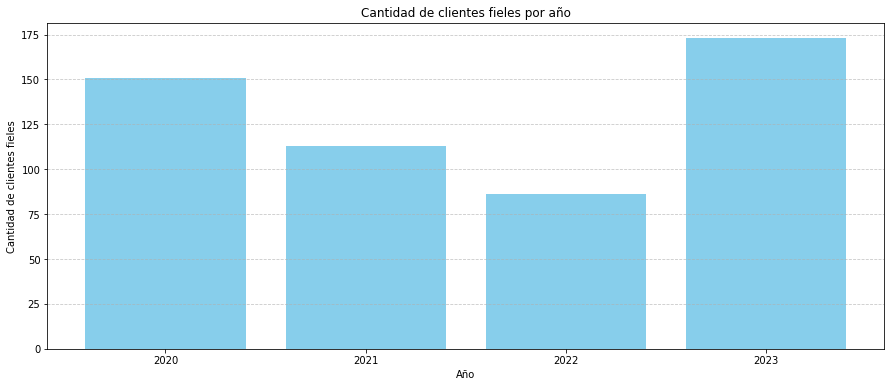

In [ ]:
anios = [anio for anio, _ in clientes_fieles_por_anio]
cantidad_clientes_fieles = [len(clientes_fieles_anio) for _, clientes_fieles_anio in clientes_fieles_por_anio]

plt.figure(figsize=(15, 6))
plt.bar(anios, cantidad_clientes_fieles, color='skyblue')
plt.xlabel('Año')
plt.ylabel('Cantidad de clientes fieles')
plt.title('Cantidad de clientes fieles por año')
plt.xticks(anios)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
print(cantidad_clientes_fieles)

[151, 113, 86, 173]


In [ ]:
clientes_repetidos = {}

for comb in combinations(clientes_fieles_por_anio, 2):
    clientes_anios = [set(clientes) for _, clientes in comb]
    clientes_repetidos_comb = set.intersection(*clientes_anios)

    if clientes_repetidos_comb:
        anos_repetidos = [anio for anio, _ in comb]

        if len(anos_repetidos) == 2:
            clientes_repetidos[tuple(sorted(anos_repetidos))] = clientes_repetidos_comb

for comb in combinations(clientes_fieles_por_anio, 3):
    clientes_anios = [set(clientes) for _, clientes in comb]
    clientes_repetidos_comb = set.intersection(*clientes_anios)

    if clientes_repetidos_comb:
        anos_repetidos = [anio for anio, _ in comb]
        clientes_repetidos[tuple(sorted(anos_repetidos))] = clientes_repetidos_comb

for anos, clientes in clientes_repetidos.items():
    print(f"Clientes que se repiten en los años {' y en los años '.join(map(str, anos))} son:")
    print(', '.join(map(str, clientes)))

Clientes que se repiten en los años 2020 y en los años 2021 son:
2478.0, 5008.0, 3990.0, 314.0, 4511.0
Clientes que se repiten en los años 2020 y en los años 2022 son:
1862.0, 2478.0, 657.0, 530.0, 1746.0, 1271.0, 314.0
Clientes que se repiten en los años 2020 y en los años 2023 son:
1282.0, 21.0, 2478.0, 1271.0
Clientes que se repiten en los años 2021 y en los años 2022 son:
3880.0, 233.0, 2478.0, 3472.0, 25.0, 314.0, 3391.0
Clientes que se repiten en los años 2021 y en los años 2023 son:
4616.0, 3880.0, 2478.0, 3739.0, 4574.0
Clientes que se repiten en los años 2022 y en los años 2023 son:
993.0, 3015.0, 3880.0, 424.0, 1162.0, 4236.0, 2478.0, 4879.0, 4913.0, 1399.0, 1271.0, 5053.0
Clientes que se repiten en los años 2020 y en los años 2021 y en los años 2022 son:
314.0, 2478.0
Clientes que se repiten en los años 2020 y en los años 2021 y en los años 2023 son:
2478.0
Clientes que se repiten en los años 2020 y en los años 2022 y en los años 2023 son:
2478.0, 1271.0
Clientes que se repi

### Compras por clientes fieles

In [ ]:
promedio_compras_por_mes_por_cliente_fiel_por_anio = {}

for anio in range(2020, 2024):
    promedio_compras_por_mes_por_cliente_fiel_por_anio[anio] = promedio_compras_por_mes_por_cliente_fiel(df_clientes, anio)

for anio, promedio_compras_por_mes_por_cliente_fiel_anio in promedio_compras_por_mes_por_cliente_fiel_por_anio.items():
    print(f"Promedio de compras por mes por cliente fiel en el año {anio}:")
    print(promedio_compras_por_mes_por_cliente_fiel_anio)


Promedio de compras por mes por cliente fiel en el año 2020:
client_id
21.0      2.090909
129.0     1.000000
132.0     1.000000
173.0     2.000000
217.0     1.000000
            ...   
4832.0    1.111111
4880.0    1.500000
4892.0    1.000000
5008.0    2.000000
5119.0    1.500000
Name: compras, Length: 151, dtype: float64
Promedio de compras por mes por cliente fiel en el año 2021:
client_id
25.0      3.5
35.0      1.0
74.0      1.0
169.0     1.0
188.0     1.0
         ... 
5044.0    1.0
5052.0    1.0
5067.0    1.5
5111.0    1.0
5155.0    1.0
Name: compras, Length: 132, dtype: float64
Promedio de compras por mes por cliente fiel en el año 2022:
client_id
25.0      3.583333
37.0      1.000000
62.0      1.000000
82.0      1.000000
86.0      1.666667
            ...   
4992.0    1.000000
5023.0    1.000000
5050.0    1.916667
5053.0    2.416667
5095.0    1.000000
Name: compras, Length: 104, dtype: float64
Promedio de compras por mes por cliente fiel en el año 2023:
client_id
14.0      11.83

In [ ]:
promedio_general_compras_totales_por_anio = {}
for anio in range(2020, 2024):
    promedio_general_compras_totales_por_anio[anio] = promedio_compras_totales_por_mes(df_clientes, anio)


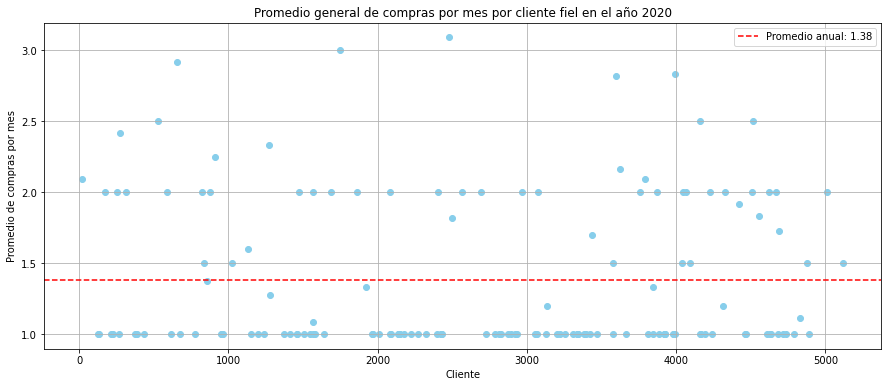

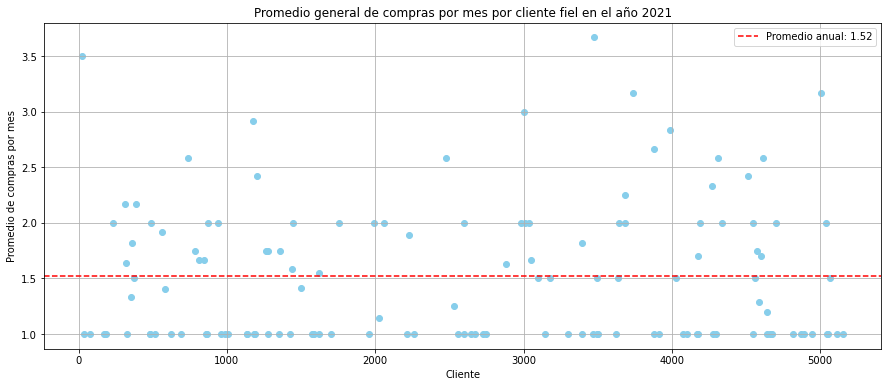

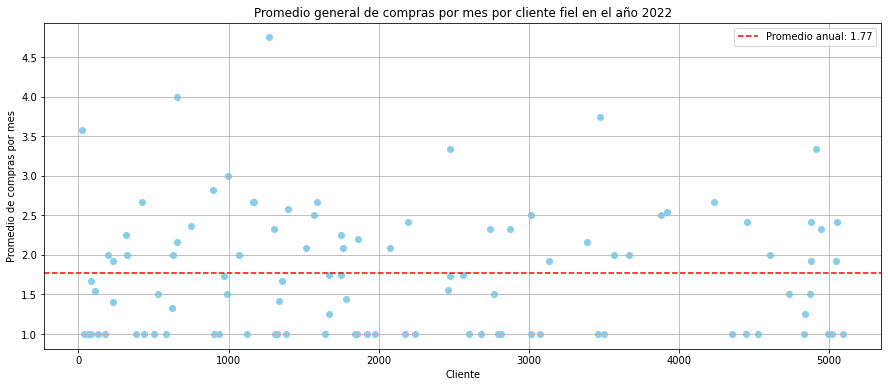

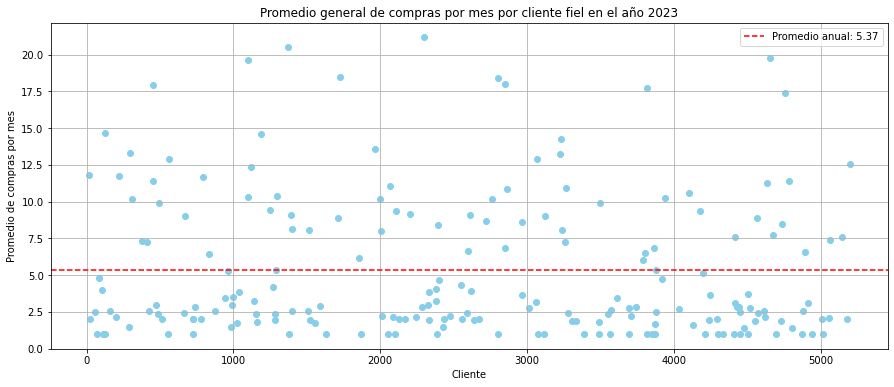

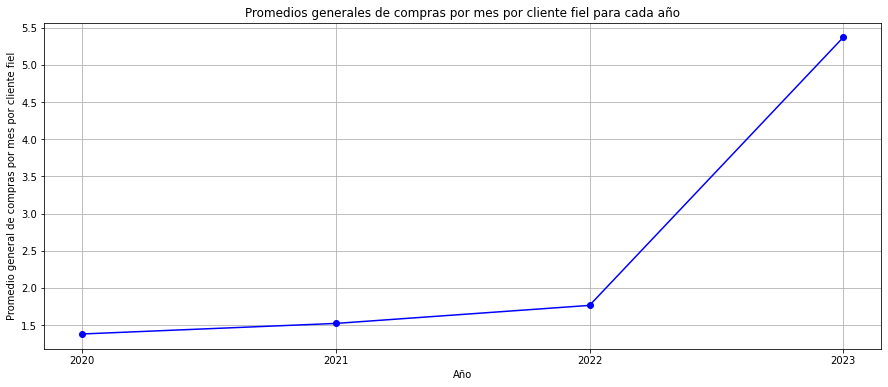

In [ ]:
promedio_general_por_anio = []

for anio, promedio_compras_por_mes_por_cliente_fiel_anio in promedio_compras_por_mes_por_cliente_fiel_por_anio.items():
    promedio_anual = promedio_compras_por_mes_por_cliente_fiel_anio.mean()
    promedio_general_por_anio.append(promedio_anual)
    clientes = list(promedio_compras_por_mes_por_cliente_fiel_anio.index)
    promedios = list(promedio_compras_por_mes_por_cliente_fiel_anio.values)
    plt.figure(figsize=(15, 6))
    plt.scatter(clientes, promedios, color='skyblue')
    plt.axhline(y=promedio_anual, color='red', linestyle='--', label=f'Promedio anual: {promedio_anual:.2f}')
    plt.xlabel('Cliente')
    plt.ylabel('Promedio de compras por mes')
    plt.title(f'Promedio general de compras por mes por cliente fiel en el año {anio}')
    plt.legend()
    plt.grid(True)
    plt.show()

plt.figure(figsize=(15, 6))
plt.plot(range(2020, 2024), promedio_general_por_anio, marker='o', color='blue', linestyle='-')
plt.xlabel('Año')
plt.ylabel('Promedio general de compras por mes por cliente fiel')
plt.title('Promedios generales de compras por mes por cliente fiel para cada año')
plt.grid(True)
plt.xticks(range(2020, 2024))
plt.show()

In [ ]:
print(promedio_general_por_anio)

[1.3808733025620443, 1.5228078949669857, 1.765166083916084, 5.368209235209235]


In [ ]:
promedio_general_por_anio = []
promedio_total_por_anio = []

for anio, promedio_compras_por_mes_por_cliente_fiel_anio in promedio_compras_por_mes_por_cliente_fiel_por_anio.items():
    promedio_anual = promedio_compras_por_mes_por_cliente_fiel_anio.mean()
    promedio_general_por_anio.append(promedio_anual)
    promedio_total_anual = promedio_general_compras_totales_por_anio[anio]
    promedio_total_por_anio.append(promedio_total_anual)

    clientes = list(promedio_compras_por_mes_por_cliente_fiel_anio.index)
    promedios = list(promedio_compras_por_mes_por_cliente_fiel_anio.values)

    plt.figure(figsize=(15, 6))
    plt.scatter(clientes, promedios, color='skyblue')
    plt.axhline(y=promedio_anual, color='red', linestyle='--', label=f'Promedio anual: {promedio_anual:.2f}')
    plt.xlabel('Cliente')
    plt.title(f'Promedio general de compras por mes por cliente fiel en el año {anio}')
    plt.legend()
    plt.grid(True)
    plt.show()

plt.figure(figsize=(15, 6))
plt.plot(range(2020, 2024), promedio_general_por_anio, marker='o', color='blue', linestyle='-')
plt.xlabel('Año')
plt.ylabel('Promedio general de compras por mes')
plt.title('Promedios generales de compras por mes para cada año')
plt.legend()
plt.grid(True)
plt.xticks(range(2020, 2024))
plt.show()

NameError: name 'promedio_general_compras_totales_por_anio' is not defined

In [ ]:
print(promedio_general_por_anio)
print(promedio_total_por_anio)

[1.3808733025620443, 1.5228078949669857, 1.765166083916084, 5.368209235209235]
[3551.6666666666665, 4291.0, 4827.75, 5022.333333333333]


In [ ]:
compras_clientes_fieles_por_mes_por_anio = {}

for anio in range(2020, 2024):
    compras_clientes_fieles_por_mes_por_anio[anio] = compras_por_mes(df_clientes, anio)

for anio, compras_clientes_fieles_por_mes in compras_clientes_fieles_por_mes_por_anio.items():
    print(f"Cantidades promedio de compras por mes para todos los clientes fieles del año {anio}:")
    print(compras_clientes_fieles_por_mes)

Cantidades promedio de compras por mes para todos los clientes fieles del año 2020:
date
1     1.166667
2     1.205128
3     1.310345
4     1.200000
5     1.203390
6     1.281250
7     1.163636
8     1.261538
9     1.196970
10    1.300000
11    1.317757
12    1.303571
Name: quantity, dtype: float64
Cantidades promedio de compras por mes para todos los clientes fieles del año 2021:
date
1     1.338462
2     1.293333
3     1.294872
4     1.320513
5     1.376623
6     1.333333
7     1.274725
8     1.297030
9     1.298969
10    1.369048
11    1.300000
12    1.328704
Name: quantity, dtype: float64
Cantidades promedio de compras por mes para todos los clientes fieles del año 2022:
date
1     1.200000
2     1.203704
3     1.208054
4     1.224490
5     1.212121
6     1.284615
7     1.220588
8     1.239669
9     1.239669
10    1.203252
11    1.184397
12    1.285714
Name: quantity, dtype: float64
Cantidades promedio de compras por mes para todos los clientes fieles del año 2023:
date
1     1.049

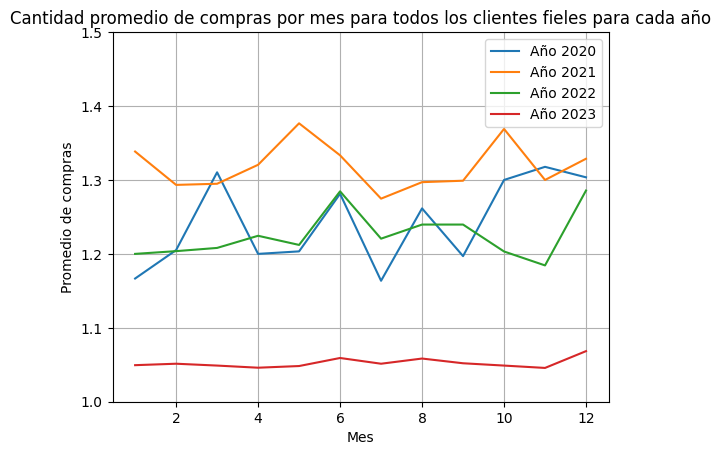

In [ ]:
# Graficar los datos
total_compras = []
promedio_total = []
for anio, compras_clientes_fieles_meses in compras_clientes_fieles_por_mes_por_anio.items():
    meses = list(range(1, 13))  # Asumiendo que los meses van de 1 a 12
    compras = compras_clientes_fieles_meses  # Suponiendo que las compras son un numpy array
    total_compras.append(compras)
    promedio_total.append(compras.mean())
    plt.plot(meses, compras, label=f'Año {anio}')

plt.xlabel('Mes')
plt.ylabel('Promedio de compras')
plt.title('Cantidad promedio de compras por mes para todos los clientes fieles para cada año')
plt.legend(loc='upper right')  # Coloca la leyenda en la esquina superior derecha
plt.grid(True)

# Ajusta los límites del eje y para que lleguen hasta 1.5
plt.ylim(1, 1.5)

plt.show()

In [ ]:
print(total_compras)

NameError: name 'total_compras' is not defined

In [ ]:
print(promedio_total)

[1.2425210408292748, 1.3188009641456702, 1.2255228622715282, 1.0523408317165541]


### Ganancias por clientes fieles

In [ ]:
porcentaje_contribucion_clientes_fieles_por_mes_por_anio = {}

for anio in range(2020, 2024):
    porcentaje_contribucion_clientes_fieles_por_mes_por_anio[anio] = ganancias_por_mes(df_clientes, anio)

for anio, porcentaje_contribucion_clientes_fieles_por_mes in porcentaje_contribucion_clientes_fieles_por_mes_por_anio.items():
    print(f"Porcentaje de contribución de los clientes fieles por mes para el año {anio}:")
    print(porcentaje_contribucion_clientes_fieles_por_mes)

Porcentaje de contribución de los clientes fieles por mes para el año 2020:
date
1     1.140894
2     1.874216
3     2.517268
4     1.989483
5     2.670543
6     2.840671
7     2.221327
8     2.380452
9     2.289159
10    3.495560
11    3.659023
12    7.547635
Name: total (CLP), dtype: float64
Porcentaje de contribución de los clientes fieles por mes para el año 2021:
date
1     2.187929
2     2.266062
3     2.036425
4     2.862624
5     2.492264
6     3.056002
7     2.700803
8     2.798445
9     2.761730
10    3.202781
11    3.156262
12    5.338068
Name: total (CLP), dtype: float64
Porcentaje de contribución de los clientes fieles por mes para el año 2022:
date
1     2.705632
2     3.325902
3     3.943185
4     5.209058
5     4.141700
6     3.936638
7     3.765508
8     3.809029
9     4.143475
10    3.858746
11    3.927387
12    5.057324
Name: total (CLP), dtype: float64
Porcentaje de contribución de los clientes fieles por mes para el año 2023:
date
1     17.326113
2     19.550532
3 

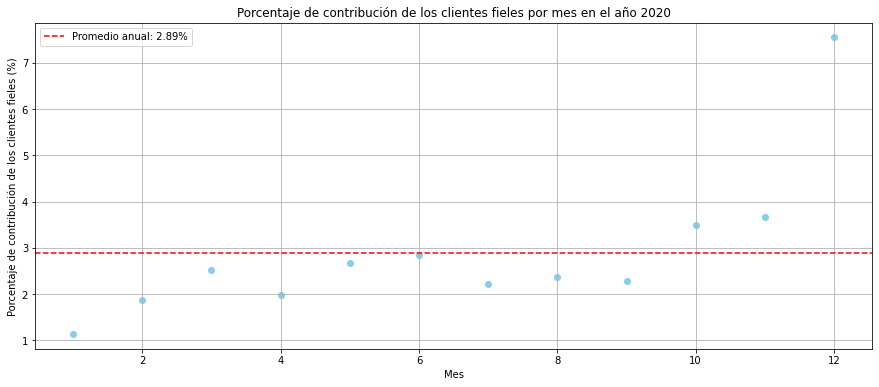

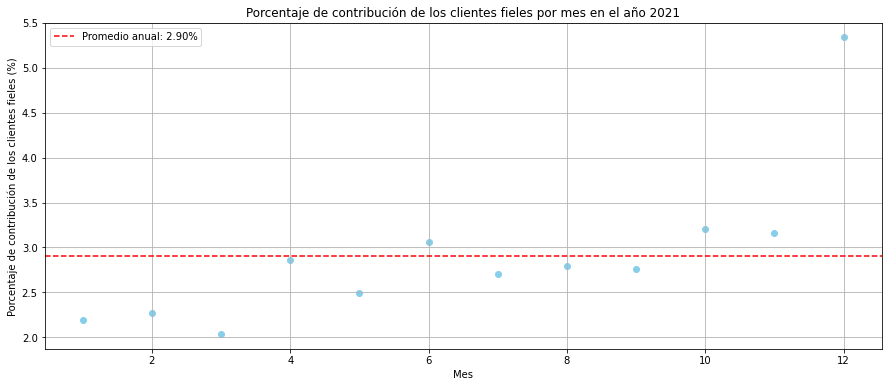

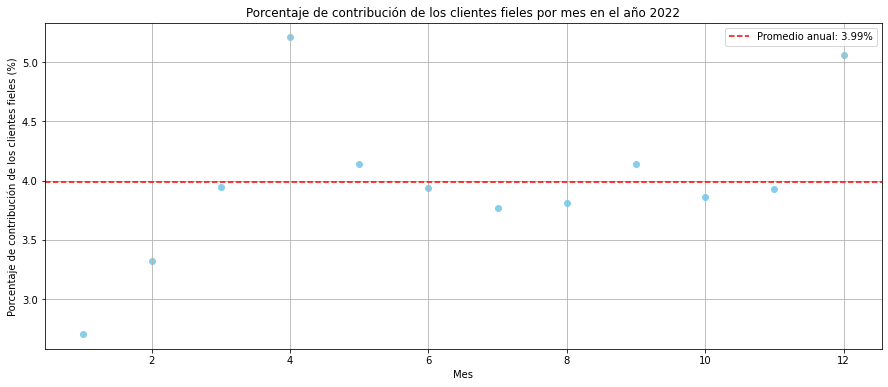

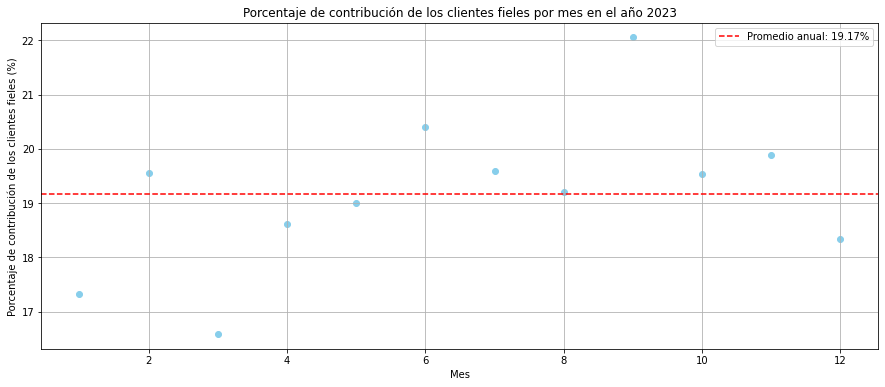

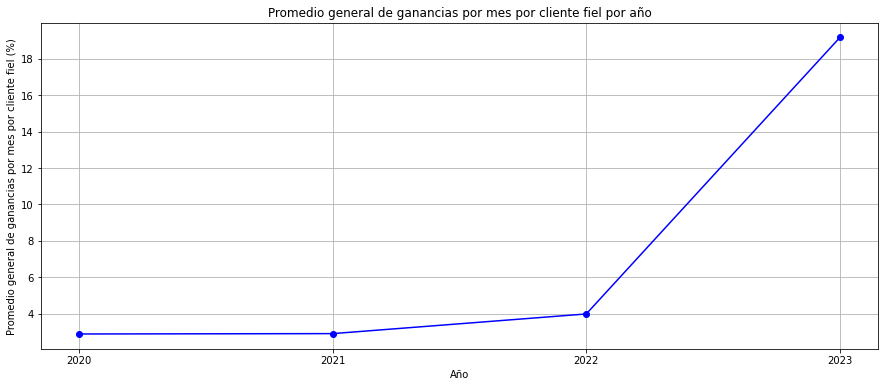

In [ ]:
promedio_general_por_anio = []

for anio, porcentaje_contribucion_clientes_fieles_por_mes in porcentaje_contribucion_clientes_fieles_por_mes_por_anio.items():
    promedio_anual = porcentaje_contribucion_clientes_fieles_por_mes.mean()
    promedio_general_por_anio.append(promedio_anual)
    meses = list(porcentaje_contribucion_clientes_fieles_por_mes.index)
    porcentajes = list(porcentaje_contribucion_clientes_fieles_por_mes.values)
    plt.figure(figsize=(15, 6))
    plt.scatter(meses, porcentajes, color='skyblue')
    plt.axhline(y=promedio_anual, color='red', linestyle='--', label=f'Promedio anual: {promedio_anual:.2f}%')
    plt.xlabel('Mes')
    plt.ylabel('Porcentaje de contribución de los clientes fieles (%)')
    plt.title(f'Porcentaje de contribución de los clientes fieles por mes en el año {anio}')
    plt.legend()
    plt.grid(True)
    plt.show()

anios = list(porcentaje_contribucion_clientes_fieles_por_mes_por_anio.keys())
promedio_general_por_anio = [np.mean(porcentajes) for porcentajes in porcentaje_contribucion_clientes_fieles_por_mes_por_anio.values()]
meses = np.tile(np.arange(1, 13), len(anios))
plt.figure(figsize=(15, 6))
plt.plot(anios, promedio_general_por_anio, marker='o', color='blue', linestyle='-')
plt.xlabel('Año')
plt.ylabel('Promedio general de ganancias por mes por cliente fiel (%)')
plt.title('Promedio general de ganancias por mes por cliente fiel por año')
plt.grid(True)
plt.xticks(anios)
plt.show()

In [ ]:
promedio_general_por_anio

[2.885519295602126, 2.904949532903785, 3.9852987430340954, 19.174456610639]

## Productos

### Clientes fieles

In [ ]:
resultados_por_anio = {}

for anio in range(2020, 2024):
    productos_por_anio = productos_comprados_por_clientes_fieles(df_clientes, anio)
    resultados_por_anio[anio] = productos_por_anio

for anio, productos in resultados_por_anio.items():
    print(f"Productos comprados por clientes fieles en {anio}:")
    print(productos)


Productos comprados por clientes fieles en 2020:
     item_id  quantity
100     1849        69
75      1799        61
66      1786        57
74      1798        48
101     1850        48
..       ...       ...
81      1807         1
14       596         1
60      1717         1
20       637         1
24       699         1

[105 rows x 2 columns]
Productos comprados por clientes fieles en 2021:
     item_id  quantity
84      1788        99
127     1854        76
86      1790        67
123     1849        56
106     1818        56
..       ...       ...
27       623         1
24       584         1
22       545         1
21       543         1
130     1858         1

[131 rows x 2 columns]
Productos comprados por clientes fieles en 2022:
     item_id  quantity
121     1849       160
125     1853       156
87      1789       126
85      1786        95
86      1788        87
..       ...       ...
37       861         1
82      1771         1
18       386         1
51      1185         1


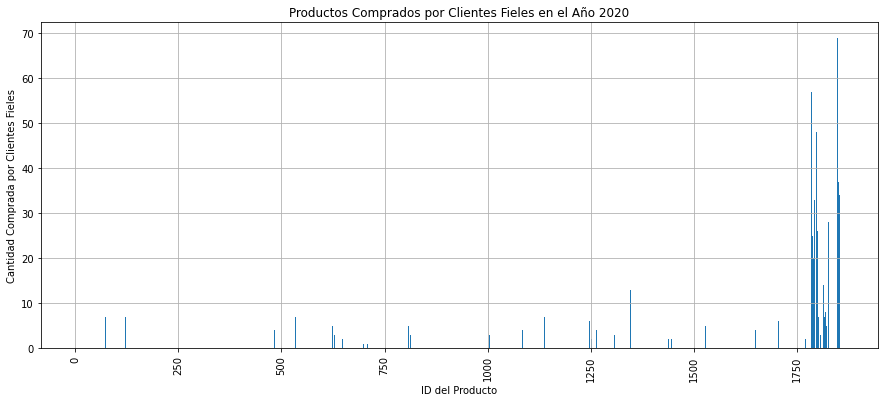

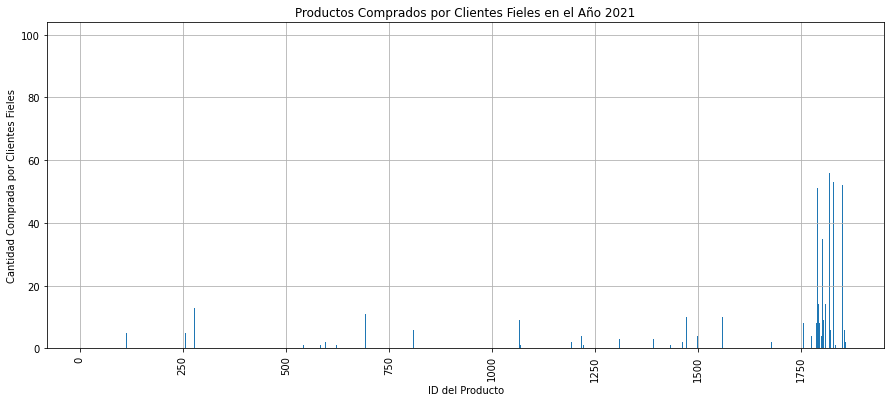

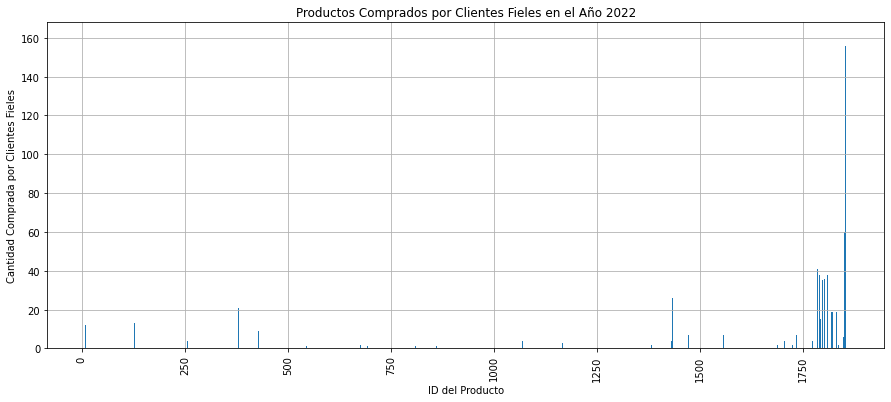

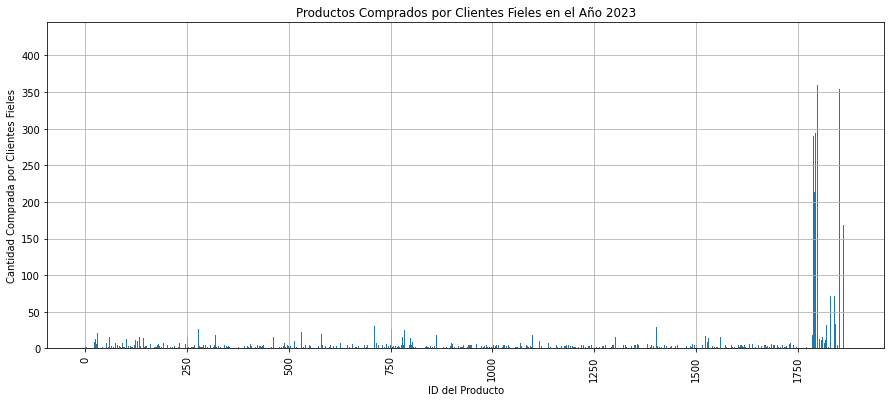

In [ ]:
for anio, productos in resultados_por_anio.items():
    plt.figure(figsize=(15, 6))
    plt.bar(productos['item_id'], productos['quantity'])
    plt.xlabel('ID del Producto')
    plt.ylabel('Cantidad Comprada por Clientes Fieles')
    plt.title(f'Productos Comprados por Clientes Fieles en el Año {anio}')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()



In [ ]:
# Crear un diccionario para almacenar la suma de la cantidad por item_id
suma_cantidad_por_item_id = {}

# Iterar sobre cada año en resultados_por_anio
for anio, productos in resultados_por_anio.items():
    # Excluir el año 2024
    if anio != 2024:
        # Iterar sobre cada fila (producto) en el DataFrame de productos
        for _, producto in productos.iterrows():
            # Obtener el item_id y la cantidad comprada
            item_id = producto['item_id']
            cantidad = producto['quantity']
            # Sumar la cantidad al total acumulado para el item_id actual
            suma_cantidad_por_item_id[item_id] = suma_cantidad_por_item_id.get(item_id, 0) + cantidad

# Ordenar el diccionario por valor (cantidad total) en orden decreciente
suma_cantidad_por_item_id_ordenado = dict(sorted(suma_cantidad_por_item_id.items(), key=lambda item: item[1], reverse=True))

# Imprimir la suma de la cantidad por item_id ordenada por cantidad total en orden decreciente
for item_id, cantidad in suma_cantidad_por_item_id_ordenado.items():
    print(f"Item ID: {item_id}, Cantidad Total: {cantidad}")

Item ID: 1849, Cantidad Total: 661
Item ID: 1790, Cantidad Total: 566
Item ID: 1853, Cantidad Total: 559
Item ID: 1850, Cantidad Total: 542
Item ID: 1800, Cantidad Total: 525
Item ID: 1789, Cantidad Total: 479
Item ID: 1851, Cantidad Total: 471
Item ID: 1799, Cantidad Total: 470
Item ID: 1785, Cantidad Total: 458
Item ID: 1801, Cantidad Total: 444
Item ID: 1788, Cantidad Total: 431
Item ID: 1786, Cantidad Total: 428
Item ID: 1797, Cantidad Total: 370
Item ID: 1795, Cantidad Total: 367
Item ID: 1794, Cantidad Total: 324
Item ID: 1796, Cantidad Total: 320
Item ID: 1867, Cantidad Total: 313
Item ID: 1860, Cantidad Total: 275
Item ID: 1792, Cantidad Total: 256
Item ID: 1861, Cantidad Total: 253
Item ID: 1854, Cantidad Total: 227
Item ID: 1791, Cantidad Total: 197
Item ID: 1863, Cantidad Total: 169
Item ID: 1813, Cantidad Total: 162
Item ID: 1869, Cantidad Total: 156
Item ID: 1798, Cantidad Total: 155
Item ID: 1818, Cantidad Total: 142
Item ID: 1827, Cantidad Total: 129
Item ID: 1852, Canti

In [ ]:
# Crear un diccionario para almacenar la cantidad de veces que se compró cada producto por año
conteo_compras_por_item_id = {}

# Iterar sobre cada año en resultados_por_anio
for anio, productos in resultados_por_anio.items():
    # Excluir el año 2024
    if anio != 2024:
        # Iterar sobre cada fila (producto) en el DataFrame de productos
        for _, producto in productos.iterrows():
            # Obtener el item_id
            item_id = producto['item_id']
            # Incrementar el contador de compras para el item_id actual
            conteo_compras_por_item_id[item_id] = conteo_compras_por_item_id.get(item_id, 0) + 1

# Filtrar los productos que se compraron más de una vez en cada año
productos_frecuentes_por_anio = {item_id: cantidad for item_id, cantidad in conteo_compras_por_item_id.items() if cantidad > 1}

# Crear un diccionario para almacenar la suma de la cantidad por item_id
suma_cantidad_por_item_id = {}

# Iterar sobre cada año en resultados_por_anio
for anio, productos in resultados_por_anio.items():
    # Excluir el año 2024
    if anio != 2024:
        # Iterar sobre cada fila (producto) en el DataFrame de productos
        for _, producto in productos.iterrows():
            # Obtener el item_id y la cantidad comprada
            item_id = producto['item_id']
            cantidad = producto['quantity']
            # Verificar si el item_id es frecuente (se compró más de una vez en el año)
            if item_id in productos_frecuentes_por_anio:
                # Sumar la cantidad al total acumulado para el item_id actual
                suma_cantidad_por_item_id[item_id] = suma_cantidad_por_item_id.get(item_id, 0) + cantidad

# Ordenar el diccionario por valor (cantidad total) en orden decreciente
suma_cantidad_por_item_id_ordenado = dict(sorted(suma_cantidad_por_item_id.items(), key=lambda item: item[1], reverse=True))

# Imprimir la suma de la cantidad por item_id ordenada por cantidad total en orden decreciente
for item_id, cantidad in suma_cantidad_por_item_id_ordenado.items():
    print(f"Item ID: {item_id}, Cantidad Total: {cantidad}")

Item ID: 1849, Cantidad Total: 661
Item ID: 1790, Cantidad Total: 566
Item ID: 1853, Cantidad Total: 559
Item ID: 1850, Cantidad Total: 542
Item ID: 1800, Cantidad Total: 525
Item ID: 1789, Cantidad Total: 479
Item ID: 1851, Cantidad Total: 471
Item ID: 1799, Cantidad Total: 470
Item ID: 1785, Cantidad Total: 458
Item ID: 1801, Cantidad Total: 444
Item ID: 1788, Cantidad Total: 431
Item ID: 1786, Cantidad Total: 428
Item ID: 1797, Cantidad Total: 370
Item ID: 1795, Cantidad Total: 367
Item ID: 1794, Cantidad Total: 324
Item ID: 1796, Cantidad Total: 320
Item ID: 1792, Cantidad Total: 256
Item ID: 1854, Cantidad Total: 227
Item ID: 1791, Cantidad Total: 197
Item ID: 1813, Cantidad Total: 162
Item ID: 1798, Cantidad Total: 155
Item ID: 1818, Cantidad Total: 142
Item ID: 1827, Cantidad Total: 129
Item ID: 1852, Cantidad Total: 116
Item ID: 1828, Cantidad Total: 112
Item ID: 1793, Cantidad Total: 93
Item ID: 1831, Cantidad Total: 90
Item ID: 1812, Cantidad Total: 81
Item ID: 1809, Cantidad

In [ ]:
print(len(suma_cantidad_por_item_id_ordenado))

149


### Todos los clientes

In [ ]:
resultados_por_anio_total = {}
for anio in range(2020, 2024):
    productos_por_anio_total = productos_comprados_por_clientes(df_clientes, anio)
    resultados_por_anio_total[anio] = productos_por_anio_total

for anio, productos in resultados_por_anio_total.items():
    print(f"Productos comprados por todos los clientes en {anio}:")
    print(productos)

Productos comprados por todos los clientes en 2020:
      item_id  quantity
1163     1853      1728
1100     1790      1496
1138     1828      1227
1128     1818      1191
1161     1851      1036
...       ...       ...
486       788         1
488       791         1
907      1475         1
906      1474         1
0           2         1

[1176 rows x 2 columns]
Productos comprados por todos los clientes en 2021:
      item_id  quantity
1278     1853      1859
1215     1790      1700
1243     1818      1498
1253     1828      1302
1213     1788      1231
...       ...       ...
503       718         1
983      1430         1
982      1429         1
981      1427         1
0           0         1

[1291 rows x 2 columns]
Productos comprados por todos los clientes en 2022:
      item_id  quantity
1414     1853      2092
1351     1790      1666
1379     1818      1468
1389     1828      1454
1349     1788      1163
...       ...       ...
799      1051         1
804      1061         1
80

In [ ]:
# Crear un diccionario para almacenar la suma de la cantidad por item_id
suma_cantidad_por_item_id_total = {}

# Iterar sobre cada año en resultados_por_anio
for anio, productos in resultados_por_anio_total.items():
    # Excluir el año 2024
    if anio != 2024:
        # Iterar sobre cada fila (producto) en el DataFrame de productos
        for _, producto in productos.iterrows():
            # Obtener el item_id y la cantidad comprada
            item_id = producto['item_id']
            cantidad = producto['quantity']
            # Sumar la cantidad al total acumulado para el item_id actual
            suma_cantidad_por_item_id_total[item_id] = suma_cantidad_por_item_id_total.get(item_id, 0) + cantidad

# Ordenar el diccionario por valor (cantidad total) en orden decreciente
suma_cantidad_por_item_id_total_ordenado = dict(sorted(suma_cantidad_por_item_id_total.items(), key=lambda item: item[1], reverse=True))

# Imprimir la suma de la cantidad por item_id ordenada por cantidad total en orden decreciente
for item_id, cantidad in suma_cantidad_por_item_id_total_ordenado.items():
    print(f"Item ID: {item_id}, Cantidad Total: {cantidad}")


Item ID: 1853, Cantidad Total: 7908
Item ID: 1790, Cantidad Total: 6588
Item ID: 1818, Cantidad Total: 5737
Item ID: 1828, Cantidad Total: 5588
Item ID: 1788, Cantidad Total: 4586
Item ID: 1851, Cantidad Total: 4543
Item ID: 1850, Cantidad Total: 4403
Item ID: 1789, Cantidad Total: 4046
Item ID: 1800, Cantidad Total: 3865
Item ID: 1785, Cantidad Total: 3798
Item ID: 1849, Cantidad Total: 3798
Item ID: 1817, Cantidad Total: 3707
Item ID: 1799, Cantidad Total: 3634
Item ID: 1786, Cantidad Total: 3336
Item ID: 1854, Cantidad Total: 3070
Item ID: 1801, Cantidad Total: 3059
Item ID: 1813, Cantidad Total: 2920
Item ID: 1831, Cantidad Total: 2786
Item ID: 1794, Cantidad Total: 2766
Item ID: 1812, Cantidad Total: 2599
Item ID: 1795, Cantidad Total: 2570
Item ID: 1797, Cantidad Total: 2416
Item ID: 1827, Cantidad Total: 2387
Item ID: 1798, Cantidad Total: 2341
Item ID: 1792, Cantidad Total: 2276
Item ID: 1830, Cantidad Total: 2270
Item ID: 1847, Cantidad Total: 2260
Item ID: 1832, Cantidad Tota

In [ ]:
# Crear un diccionario para almacenar la cantidad de veces que se compró cada producto por año
conteo_compras_por_item_id_total = {}

# Iterar sobre cada año en resultados_por_anio
for anio, productos in resultados_por_anio_total.items():
    # Excluir el año 2024
    if anio != 2024:
        # Iterar sobre cada fila (producto) en el DataFrame de productos
        for _, producto in productos.iterrows():
            # Obtener el item_id
            item_id = producto['item_id']
            # Incrementar el contador de compras para el item_id actual
            conteo_compras_por_item_id_total[item_id] = conteo_compras_por_item_id_total.get(item_id, 0) + 1

# Filtrar los productos que se compraron más de una vez en cada año
productos_frecuentes_por_anio_total = {item_id: cantidad for item_id, cantidad in conteo_compras_por_item_id_total.items() if cantidad > 1}

# Crear un diccionario para almacenar la suma de la cantidad por item_id para productos frecuentes
suma_cantidad_productos_frecuentes_total = {}

# Iterar sobre cada año en resultados_por_anio
for anio, productos in resultados_por_anio_total.items():
    # Excluir el año 2024
    if anio != 2024:
        # Iterar sobre cada fila (producto) en el DataFrame de productos
        for _, producto in productos.iterrows():
            # Obtener el item_id y la cantidad comprada
            item_id = producto['item_id']
            cantidad = producto['quantity']
            # Verificar si el item_id es frecuente (se compró más de una vez en el año)
            if item_id in productos_frecuentes_por_anio:
                # Sumar la cantidad al total acumulado para el item_id actual
                suma_cantidad_productos_frecuentes_total[item_id] = suma_cantidad_productos_frecuentes_total.get(item_id, 0) + cantidad

# Ordenar el diccionario por valor (cantidad total) en orden decreciente
suma_cantidad_productos_frecuentes_total_ordenado = dict(sorted(suma_cantidad_productos_frecuentes_total.items(), key=lambda item: item[1], reverse=True))

# Imprimir la suma de la cantidad por item_id ordenada por cantidad total en orden decreciente
for item_id, cantidad in suma_cantidad_productos_frecuentes_total_ordenado.items():
    print(f"Item ID: {item_id}, Cantidad Total: {cantidad}")

Item ID: 1853, Cantidad Total: 7908
Item ID: 1790, Cantidad Total: 6588
Item ID: 1818, Cantidad Total: 5737
Item ID: 1828, Cantidad Total: 5588
Item ID: 1788, Cantidad Total: 4586
Item ID: 1851, Cantidad Total: 4543
Item ID: 1850, Cantidad Total: 4403
Item ID: 1789, Cantidad Total: 4046
Item ID: 1800, Cantidad Total: 3865
Item ID: 1785, Cantidad Total: 3798
Item ID: 1849, Cantidad Total: 3798
Item ID: 1817, Cantidad Total: 3707
Item ID: 1799, Cantidad Total: 3634
Item ID: 1786, Cantidad Total: 3336
Item ID: 1854, Cantidad Total: 3070
Item ID: 1801, Cantidad Total: 3059
Item ID: 1813, Cantidad Total: 2920
Item ID: 1831, Cantidad Total: 2786
Item ID: 1794, Cantidad Total: 2766
Item ID: 1812, Cantidad Total: 2599
Item ID: 1795, Cantidad Total: 2570
Item ID: 1797, Cantidad Total: 2416
Item ID: 1827, Cantidad Total: 2387
Item ID: 1798, Cantidad Total: 2341
Item ID: 1792, Cantidad Total: 2276
Item ID: 1830, Cantidad Total: 2270
Item ID: 1847, Cantidad Total: 2260
Item ID: 1832, Cantidad Tota

In [ ]:
print(len(suma_cantidad_productos_frecuentes_total_ordenado))

149


### No fieles

In [ ]:
resultados_por_anio_no_fiel = {}

for anio in range(2020, 2024):
    productos_por_anio_no_fiel = productos_comprados_por_clientes_no_fieles(df_clientes, anio)
    resultados_por_anio_no_fiel[anio] = productos_por_anio_no_fiel

for anio, productos in resultados_por_anio_no_fiel.items():
    print(f"Productos comprados por clientes no fieles en {anio}:")
    print(productos)

Productos comprados por clientes no fieles en 2020:
      item_id  quantity
1161     1851       999
1163     1853       972
1160     1850       925
1099     1789       891
1095     1785       861
...       ...       ...
486       788         1
488       791         1
907      1475         1
906      1474         1
0           2         1

[1176 rows x 2 columns]
Productos comprados por clientes no fieles en 2021:
      item_id  quantity
1278     1853      1125
1276     1851      1107
1275     1850       998
1210     1785       956
1214     1789       950
...       ...       ...
983      1430         1
982      1429         1
981      1427         1
980      1426         1
0           0         1

[1291 rows x 2 columns]
Productos comprados por clientes no fieles en 2022:
      item_id  quantity
1414     1853      1089
1412     1851      1074
1411     1850      1071
1361     1800       936
1350     1789       915
...       ...       ...
799      1051         1
804      1061         1
80

In [ ]:
# Crear un diccionario para almacenar la suma de la cantidad por item_id
suma_cantidad_por_item_id_no_fiel = {}

# Iterar sobre cada año en resultados_por_anio
for anio, productos in resultados_por_anio_no_fiel.items():
    # Excluir el año 2024
    if anio != 2024:
        # Iterar sobre cada fila (producto) en el DataFrame de productos
        for _, producto in productos.iterrows():
            # Obtener el item_id y la cantidad comprada
            item_id = producto['item_id']
            cantidad = producto['quantity']
            # Sumar la cantidad al total acumulado para el item_id actual
            suma_cantidad_por_item_id_no_fiel[item_id] = suma_cantidad_por_item_id_no_fiel.get(item_id, 0) + cantidad

# Ordenar el diccionario por valor (cantidad total) en orden decreciente
suma_cantidad_por_item_id_no_fiel_ordenado = dict(sorted(suma_cantidad_por_item_id_no_fiel.items(), key=lambda item: item[1], reverse=True))

# Imprimir la suma de la cantidad por item_id ordenada por cantidad total en orden decreciente
for item_id, cantidad in suma_cantidad_por_item_id_no_fiel_ordenado.items():
    print(f"Item ID: {item_id}, Cantidad Total: {cantidad}")

Item ID: 1853, Cantidad Total: 4159
Item ID: 1851, Cantidad Total: 4072
Item ID: 1850, Cantidad Total: 3861
Item ID: 1789, Cantidad Total: 3567
Item ID: 1785, Cantidad Total: 3340
Item ID: 1800, Cantidad Total: 3340
Item ID: 1828, Cantidad Total: 3306
Item ID: 1818, Cantidad Total: 3292
Item ID: 1799, Cantidad Total: 3164
Item ID: 1849, Cantidad Total: 3137
Item ID: 1790, Cantidad Total: 3094
Item ID: 1786, Cantidad Total: 2908
Item ID: 1788, Cantidad Total: 2901
Item ID: 1854, Cantidad Total: 2843
Item ID: 1813, Cantidad Total: 2758
Item ID: 1831, Cantidad Total: 2696
Item ID: 1817, Cantidad Total: 2639
Item ID: 1801, Cantidad Total: 2615
Item ID: 1812, Cantidad Total: 2518
Item ID: 1794, Cantidad Total: 2442
Item ID: 1827, Cantidad Total: 2258
Item ID: 1795, Cantidad Total: 2203
Item ID: 1830, Cantidad Total: 2194
Item ID: 1798, Cantidad Total: 2186
Item ID: 1847, Cantidad Total: 2186
Item ID: 1797, Cantidad Total: 2046
Item ID: 1829, Cantidad Total: 2021
Item ID: 1792, Cantidad Tota

In [ ]:
# Crear un diccionario para almacenar la cantidad de veces que se compró cada producto por año
conteo_compras_por_item_id_no_fiel = {}

# Iterar sobre cada año en resultados_por_anio
for anio, productos in resultados_por_anio_no_fiel.items():
    # Excluir el año 2024
    if anio != 2024:
        # Iterar sobre cada fila (producto) en el DataFrame de productos
        for _, producto in productos.iterrows():
            # Obtener el item_id
            item_id = producto['item_id']
            # Incrementar el contador de compras para el item_id actual
            conteo_compras_por_item_id_no_fiel[item_id] = conteo_compras_por_item_id_no_fiel.get(item_id, 0) + 1

# Filtrar los productos que se compraron más de una vez en cada año
productos_frecuentes_por_anio_no_fiel = {item_id: cantidad for item_id, cantidad in conteo_compras_por_item_id_no_fiel.items() if cantidad > 1}

# Crear un diccionario para almacenar la suma de la cantidad por item_id
suma_cantidad_por_item_id_no_fiel = {}

# Iterar sobre cada año en resultados_por_anio
for anio, productos in resultados_por_anio_no_fiel.items():
    # Excluir el año 2024
    if anio != 2024:
        # Iterar sobre cada fila (producto) en el DataFrame de productos
        for _, producto in productos.iterrows():
            # Obtener el item_id y la cantidad comprada
            item_id = producto['item_id']
            cantidad = producto['quantity']
            # Verificar si el item_id es frecuente (se compró más de una vez en el año)
            if item_id in productos_frecuentes_por_anio_no_fiel:
                # Sumar la cantidad al total acumulado para el item_id actual
                suma_cantidad_por_item_id_no_fiel[item_id] = suma_cantidad_por_item_id_no_fiel.get(item_id, 0) + cantidad

# Ordenar el diccionario por valor (cantidad total) en orden decreciente
suma_cantidad_por_item_id_ordenado_no_fiel = dict(sorted(suma_cantidad_por_item_id_no_fiel.items(), key=lambda item: item[1], reverse=True))

# Imprimir la suma de la cantidad por item_id ordenada por cantidad total en orden decreciente
for item_id, cantidad in suma_cantidad_por_item_id_ordenado_no_fiel.items():
    print(f"Item ID: {item_id}, Cantidad Total: {cantidad}")

Item ID: 1853, Cantidad Total: 4159
Item ID: 1851, Cantidad Total: 4072
Item ID: 1850, Cantidad Total: 3861
Item ID: 1789, Cantidad Total: 3567
Item ID: 1785, Cantidad Total: 3340
Item ID: 1800, Cantidad Total: 3340
Item ID: 1828, Cantidad Total: 3306
Item ID: 1818, Cantidad Total: 3292
Item ID: 1799, Cantidad Total: 3164
Item ID: 1849, Cantidad Total: 3137
Item ID: 1790, Cantidad Total: 3094
Item ID: 1786, Cantidad Total: 2908
Item ID: 1788, Cantidad Total: 2901
Item ID: 1854, Cantidad Total: 2843
Item ID: 1813, Cantidad Total: 2758
Item ID: 1831, Cantidad Total: 2696
Item ID: 1817, Cantidad Total: 2639
Item ID: 1801, Cantidad Total: 2615
Item ID: 1812, Cantidad Total: 2518
Item ID: 1794, Cantidad Total: 2442
Item ID: 1827, Cantidad Total: 2258
Item ID: 1795, Cantidad Total: 2203
Item ID: 1830, Cantidad Total: 2194
Item ID: 1798, Cantidad Total: 2186
Item ID: 1847, Cantidad Total: 2186
Item ID: 1797, Cantidad Total: 2046
Item ID: 1829, Cantidad Total: 2021
Item ID: 1792, Cantidad Tota

In [ ]:
print(len(suma_cantidad_por_item_id_ordenado_no_fiel))

1413


### No vendidos

In [ ]:
# Obtener todos los "item_id" únicos en el DataFrame df_clientes
todos_los_item_id = df_clientes['item_id'].unique()

# Obtener los "item_id" que se han vendido (los que están en suma_cantidad_productos_frecuentes_ordenado)
item_id_vendidos = set(suma_cantidad_productos_frecuentes_total_ordenado.keys())

# Identificar los "item_id" que no se han vendido
item_id_no_vendidos = [item_id for item_id in todos_los_item_id if item_id not in item_id_vendidos]

# Imprimir los "item_id" que no se han vendido
print(f"Item IDs que no se han vendido: {item_id_no_vendidos}")
print(f"Número de Item IDs que no se han vendido: {len(item_id_no_vendidos)}")

Item IDs que no se han vendido: [471, 1842, 1116, 1860, 189, 14, 1185, 70, 1217, 281, 372, 1357, 1179, 277, 543, 966, 331, 212, 1021, 1498, 1863, 217, 916, 890, 1826, 6, 322, 123, 207, 1823, 342, 523, 1861, 768, 845, 1846, 247, 1024, 881, 268, 1679, 133, 1867, 1811, 1609, 165, 583, 1678, 834, 1107, 1716, 1844, 276, 343, 749, 1257, 721, 1810, 1674, 0, 527, 522, 1686, 1824, 1866, 1349, 1764, 1431, 183, 412, 1835, 799, 241, 889, 469, 629, 631, 1301, 808, 1856, 1408, 87, 532, 27, 1857, 1759, 1385, 1522, 763, 933, 1117, 1417, 685, 957, 623, 179, 104, 68, 395, 972, 965, 1696, 1521, 709, 32, 1340, 417, 1252, 1285, 637, 1814, 1688, 1806, 462, 480, 833, 1220, 1460, 1834, 895, 1668, 102, 638, 1694, 669, 915, 1869, 1512, 1158, 148, 1858, 1520, 595, 1573, 171, 466, 1621, 632, 1223, 1383, 26, 1562, 1338, 240, 1388, 1261, 1405, 1318, 757, 1859, 544, 754, 1598, 1090, 287, 1016, 644, 270, 1443, 220, 109, 1807, 201, 1592, 656, 59, 1129, 1833, 1120, 761, 177, 621, 62, 95, 485, 884, 585, 110, 289, 949, 8